# PhD-Level Data Analysis & Generalization: GLOBEM Dataset

## 1. Introduction & Research Objective
This study investigates the divergence between **Machine Learning Reasoning** and **Human Reasoning** in behavioral modeling. We use the **GLOBEM Dataset** as our ground truth. 

### The Challenge
Raw sensor data (thousands of features) is unintelligible to humans and causal logic. To compare "reasoning," we must first **generalize** the low-level signals into high-level **Behavioral Constructs** (e.g., `Sleep Quality`, `Social Isolation`, `Sedentary Behavior`).

### Methodology
1.  **Data Ingestion**: Robustly load longitudinal data from multiple study waves (`INS-W_1` to `INS-W_4`).
2.  **Quality Assurance**: Analyze missingness patterns and temporal stability.
3.  **Dimensionality Reduction (Generalization)**: Use Principal Component Analysis (PCA) to condense raw sensor features into latent constructs, validating with Explained Variance (Scree Plots).
4.  **Domain DAG Formulation**: Propose a "Human Logic" DAG based on valid statistical correlations.

---

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Scientific Plotting Config
sns.set_context("paper", font_scale=1.5)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

DATA_DIR = '../Data'

## 2. Multi-Wave Data Ingestion
The dataset is split across 4 waves. We define a helper to load specific feature files (e.g., `sleep.csv`) from all waves and concantenate them, creating a unified `(pid, date)` index.

In [17]:
def load_and_unify(feature_filename):
    """
    Loads a specific feature CSV from all available INS-W_* folders.
    Aligns them into a single DataFrame indexed by (pid, date).
    """
    pattern = os.path.join(DATA_DIR, 'INS-W_*', 'FeatureData', feature_filename)
    all_files = glob.glob(pattern)
    
    if not all_files:
        print(f"[ERROR] No files found for {feature_filename}")
        return pd.DataFrame()
    
    df_list = []
    print(f"Found {len(all_files)} files for '{feature_filename}':")
    for f in all_files:
        wave = f.split(os.sep)[-3]
        try:
            # Load CSV
            temp = pd.read_csv(f)
            
            # Clean Index
            if 'Unnamed: 0' in temp.columns:
                temp.drop(columns=['Unnamed: 0'], inplace=True)
            
            # Standardize Identifiers
            if 'pid' in temp.columns and 'date' in temp.columns:
                temp['wave'] = wave
                temp['date'] = pd.to_datetime(temp['date'])
                df_list.append(temp)
                print(f"  - Loaded {wave}: {temp.shape} rows")
            else:
                print(f"  - [Skipping] {wave} (Missing 'pid' or 'date' columns)")
        except Exception as e:
            print(f"  - [Error] {wave}: {e}")
            
    if not df_list:
        return pd.DataFrame()
    
    full_df = pd.concat(df_list, ignore_index=True)
    # Remove duplicates (participants might appear across waves or files)
    full_df.drop_duplicates(subset=['pid', 'date'], inplace=True)
    full_df.set_index(['pid', 'date'], inplace=True)
    
    return full_df

### 2.1 Loading Core Modalities
We load the four pillars of behavior: **Sleep** (Rest), **Steps** (Activity), **Screen** (Sedentary/Digital), and **Calls** (Social).

In [18]:
print("--- Loading Sleep Data ---")
df_sleep = load_and_unify('sleep.csv')

print("\n--- Loading Steps Data ---")
df_steps = load_and_unify('steps.csv')

print("\n--- Loading Screen Data ---")
df_screen = load_and_unify('screen.csv')

print("\n--- Loading Call Data ---")
df_call = load_and_unify('call.csv')

--- Loading Sleep Data ---
Found 4 files for 'sleep.csv':


/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_18159/1796240377.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp['wave'] = wave


  - Loaded INS-W_1: (14260, 921) rows


/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_18159/1796240377.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp['wave'] = wave


  - Loaded INS-W_2: (21146, 921) rows


/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_18159/1796240377.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp['wave'] = wave


  - Loaded INS-W_4: (20085, 921) rows


/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_18159/1796240377.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp['wave'] = wave


  - Loaded INS-W_3: (14111, 921) rows

--- Loading Steps Data ---
Found 4 files for 'steps.csv':


/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_18159/1796240377.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp['wave'] = wave


  - Loaded INS-W_1: (14260, 597) rows


/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_18159/1796240377.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp['wave'] = wave


  - Loaded INS-W_2: (21146, 597) rows


/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_18159/1796240377.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp['wave'] = wave


  - Loaded INS-W_4: (20085, 597) rows


/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_18159/1796240377.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp['wave'] = wave


  - Loaded INS-W_3: (14111, 597) rows

--- Loading Screen Data ---
Found 4 files for 'screen.csv':


/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_18159/1796240377.py:19: DtypeWarning: Columns (0: f_screen:phone_screen_rapids_countepisodeunlock_locmap_exercise_dis:night, 1: f_screen:phone_screen_rapids_sumdurationunlock_locmap_exercise_dis:night, 2: f_screen:phone_screen_rapids_maxdurationunlock_locmap_exercise_dis:night, 3: f_screen:phone_screen_rapids_mindurationunlock_locmap_exercise_dis:night, 4: f_screen:phone_screen_rapids_avgdurationunlock_locmap_exercise_dis:night, 5: f_screen:phone_screen_rapids_stddurationunlock_locmap_exercise_dis:night, 6: f_screen:phone_screen_rapids_firstuseafter00unlock_locmap_exercise_dis:night) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(f)
/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_18159/1796240377.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

  - Loaded INS-W_1: (14260, 1137) rows


/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_18159/1796240377.py:19: DtypeWarning: Columns (0: f_screen:phone_screen_rapids_countepisodeunlock_locmap_exercise_dis:night, 1: f_screen:phone_screen_rapids_sumdurationunlock_locmap_exercise_dis:night, 2: f_screen:phone_screen_rapids_maxdurationunlock_locmap_exercise_dis:night, 3: f_screen:phone_screen_rapids_mindurationunlock_locmap_exercise_dis:night, 4: f_screen:phone_screen_rapids_avgdurationunlock_locmap_exercise_dis:night, 5: f_screen:phone_screen_rapids_stddurationunlock_locmap_exercise_dis:night, 6: f_screen:phone_screen_rapids_firstuseafter00unlock_locmap_exercise_dis:night, 7: f_screen:phone_screen_rapids_stddurationunlock_locmap_greens_dis:night, 8: f_screen:phone_screen_rapids_stddurationunlock_locmap_study_dis:night) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(f)
/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_18159/1796240377.py:27: PerformanceWarning: 

  - Loaded INS-W_2: (21146, 1137) rows


/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_18159/1796240377.py:19: DtypeWarning: Columns (0: f_screen:phone_screen_rapids_stddurationunlock_locmap_living_dis:14dhist, 1: f_screen:phone_screen_rapids_stddurationunlock_locmap_study_dis:14dhist, 2: f_screen:phone_screen_rapids_stddurationunlock_locmap_living_dis:7dhist, 3: f_screen:phone_screen_rapids_stddurationunlock_locmap_study_dis:7dhist, 4: f_screen:phone_screen_rapids_countepisodeunlock_locmap_exercise_dis:afternoon, 5: f_screen:phone_screen_rapids_sumdurationunlock_locmap_exercise_dis:afternoon, 6: f_screen:phone_screen_rapids_maxdurationunlock_locmap_exercise_dis:afternoon, 7: f_screen:phone_screen_rapids_mindurationunlock_locmap_exercise_dis:afternoon, 8: f_screen:phone_screen_rapids_avgdurationunlock_locmap_exercise_dis:afternoon, 9: f_screen:phone_screen_rapids_stddurationunlock_locmap_exercise_dis:afternoon, 10: f_screen:phone_screen_rapids_firstuseafter00unlock_locmap_exercise_dis:afternoon, 11: f_screen:phon

  - Loaded INS-W_4: (20085, 1137) rows


/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_18159/1796240377.py:19: DtypeWarning: Columns (0: f_screen:phone_screen_rapids_countepisodeunlock_locmap_exercise_dis:14dhist, 1: f_screen:phone_screen_rapids_sumdurationunlock_locmap_exercise_dis:14dhist, 2: f_screen:phone_screen_rapids_maxdurationunlock_locmap_exercise_dis:14dhist, 3: f_screen:phone_screen_rapids_mindurationunlock_locmap_exercise_dis:14dhist, 4: f_screen:phone_screen_rapids_avgdurationunlock_locmap_exercise_dis:14dhist, 5: f_screen:phone_screen_rapids_stddurationunlock_locmap_exercise_dis:14dhist, 6: f_screen:phone_screen_rapids_firstuseafter00unlock_locmap_exercise_dis:14dhist, 7: f_screen:phone_screen_rapids_countepisodeunlock_locmap_greens_dis:14dhist, 8: f_screen:phone_screen_rapids_sumdurationunlock_locmap_greens_dis:14dhist, 9: f_screen:phone_screen_rapids_maxdurationunlock_locmap_greens_dis:14dhist, 10: f_screen:phone_screen_rapids_mindurationunlock_locmap_greens_dis:14dhist, 11: f_screen:phone_screen_

  - Loaded INS-W_3: (14111, 1137) rows

--- Loading Call Data ---
Found 4 files for 'call.csv':


/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_18159/1796240377.py:19: DtypeWarning: Columns (0: f_call:phone_calls_rapids_missed_timefirstcall_dis:night, 1: f_call:phone_calls_rapids_missed_timelastcall_dis:night, 2: f_call:phone_calls_rapids_incoming_stdduration_dis:night) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(f)
/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_18159/1796240377.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp['wave'] = wave


  - Loaded INS-W_1: (14260, 786) rows


/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_18159/1796240377.py:19: DtypeWarning: Columns (0: f_call:phone_calls_rapids_incoming_stdduration_dis:morning, 1: f_call:phone_calls_rapids_outgoing_stdduration_dis:night) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(f)
/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_18159/1796240377.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp['wave'] = wave


  - Loaded INS-W_2: (21146, 786) rows


/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_18159/1796240377.py:19: DtypeWarning: Columns (0: f_call:phone_calls_rapids_incoming_stdduration_dis:night) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(f)
/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_18159/1796240377.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp['wave'] = wave


  - Loaded INS-W_4: (20085, 786) rows


/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_18159/1796240377.py:19: DtypeWarning: Columns (0: f_call:phone_calls_rapids_missed_timefirstcall_dis:night, 1: f_call:phone_calls_rapids_missed_timelastcall_dis:night, 2: f_call:phone_calls_rapids_outgoing_stdduration_dis:night) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(f)
/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_18159/1796240377.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp['wave'] = wave


  - Loaded INS-W_3: (14111, 786) rows


## 3. Exploratory Data Analysis (EDA)

### 3.1 Missingness Structure
We inspect the overlap between modalities. Do we have days where users track Steps but not Sleep? This informs whether we need robust imputation or listwise deletion.

Total Unique Participant-Days: 69602


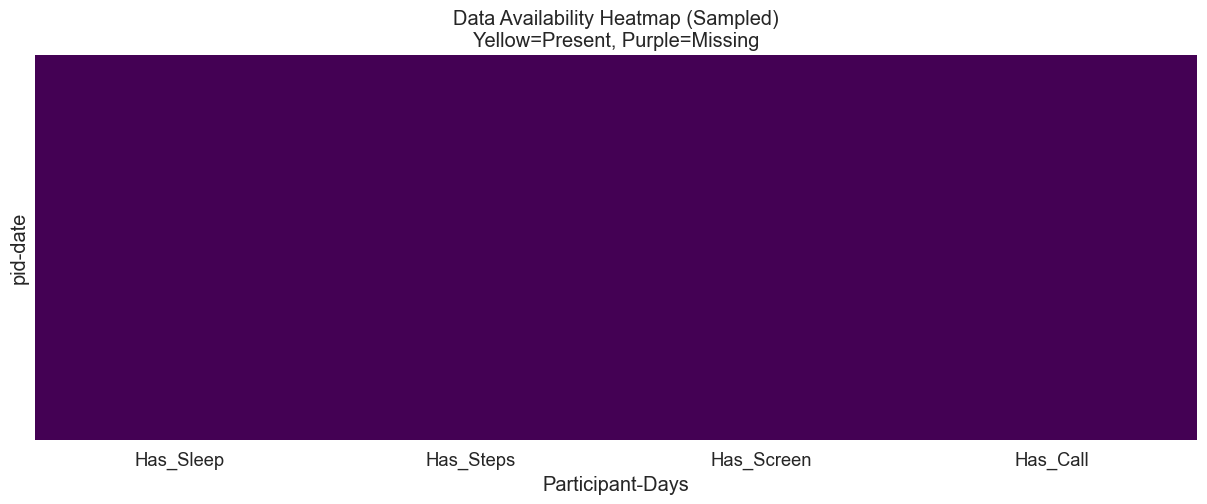

In [19]:
# Align frames by index
common_idx = df_sleep.index.union(df_steps.index).union(df_screen.index).union(df_call.index)
print(f"Total Unique Participant-Days: {len(common_idx)}")

# Create an existence matrix (1 if data present, 0 if missing)
existence = pd.DataFrame(index=common_idx)
existence['Has_Sleep'] = common_idx.isin(df_sleep.index).astype(int)
existence['Has_Steps'] = common_idx.isin(df_steps.index).astype(int)
existence['Has_Screen'] = common_idx.isin(df_screen.index).astype(int)
existence['Has_Call'] = common_idx.isin(df_call.index).astype(int)

# Visualize
plt.figure(figsize=(15, 5))
sns.heatmap(existence.sample(frac=0.5, random_state=42).sort_index(), cbar=False, cmap='viridis')
plt.title("Data Availability Heatmap (Sampled)\nYellow=Present, Purple=Missing")
plt.xlabel("Participant-Days")
plt.yticks([])
plt.show()

### 3.2 Feature Distributions (Raw)
Checking the raw distributions of key features to identify outliers or skewness before aggregation.

In [20]:
def plot_raw_distribution(df, keyword, title):
    cols = [c for c in df.columns if keyword in c]
    if not cols: 
        return
    
    # Pick top 3 columns by variance to plot
    top_cols = df[cols].var().nlargest(3).index
    
    df[top_cols].plot(kind='box', vert=False, title=f"Distribution of Key {title} Features")
    plt.xscale('symlog') # Log scale because behavioral data is often power-law distributed
    plt.show()

plot_raw_distribution(df_sleep, 'durationasleep', 'Sleep')
plot_raw_distribution(df_steps, 'sumsteps', 'Steps')

TypeError: Cannot perform reduction 'var' with string dtype

## 4. Construct Generalization (PCA)

### Theory
We cannot feed 500 "sleep" features into a Causal DAG. We assume there exists a latent variable $Z_{sleep}$ (Sleep Quality) that causes the observed features $X_1...X_n$.

We use **PCA (Principal Component Analysis)** to estimate this latent variable.
1.  **Imputation**: Fill missing values with mean (assuming missing at random for intra-subject days).
2.  **Standardization**: Scale to mean=0, var=1.
3.  **PCA**: Extract the 1st Principal Component (PC1).
4.  **Validation**: Check Explain Variance Ratio. If PC1 > 40-50%, it's a valid proxy.

In [21]:
def extract_construct_pca(df, feature_prefix, construct_name):
    """
    Extracts the first principal component from features matching 'feature_prefix'.
    Returns: Series (The Construct), and the Explained Variance Ratio.
    """
    # 1. Selection
    cols = [c for c in df.columns if feature_prefix in c]
    if not cols:
        print(f"No columns found for {feature_prefix}")
        return pd.Series(index=df.index, name=construct_name), 0.0
        
    X = df[cols].copy()
    
    # 2. Cleaning (Drop mostly empty columns)
    X = X.dropna(axis=1, thresh=len(X)*0.6)
    
    # 3. Imputation
    imputer = SimpleImputer(strategy='mean')
    try:
        X_filled = imputer.fit_transform(X)
    except:
        return pd.Series(index=df.index, name=construct_name), 0.0
        
    # 4. Standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_filled)
    
    # 5. PCA
    pca = PCA(n_components=1)
    pc1 = pca.fit_transform(X_scaled)
    variable = pd.Series(pc1.flatten(), index=df.index, name=construct_name)
    
    # Fix Directionality (optional but good for interpretabiltiy)
    # If correlation with a known 'positive' feature is negative, flip the sign.
    # E.g. If 'steps' correlates -0.9 with PC1, then PC1 is 'Inactivity'. We want 'Activity'.
    # Simple heuristic: correlate with row-sum.
    row_sums = X_filled.sum(axis=1)
    if np.corrcoef(row_sums, variable)[0,1] < 0:
        variable = -variable
        
    return variable, pca.explained_variance_ratio_[0]

### 4.1 Applying PCA to Create Constructs

In [22]:
constructs = {}
variances = {}

# Sleep
c_sleep, v_sleep = extract_construct_pca(df_sleep, 'f_slp', 'Sleep_Quality')
constructs['Sleep_Quality'] = c_sleep
variances['Sleep_Quality'] = v_sleep

# Activity (Steps)
c_steps, v_steps = extract_construct_pca(df_steps, 'f_steps', 'Physical_Activity')
constructs['Physical_Activity'] = c_steps
variances['Physical_Activity'] = v_steps

# Screen Usage
c_screen, v_screen = extract_construct_pca(df_screen, 'f_screen', 'Screen_Usage')
constructs['Screen_Usage'] = c_screen
variances['Screen_Usage'] = v_screen

# Social (Calls)
c_social, v_social = extract_construct_pca(df_call, 'f_call', 'Social_Interactions')
constructs['Social_Interactions'] = c_social
variances['Social_Interactions'] = v_social

# Join into final Dataset
df_constructs = pd.DataFrame(constructs)

# Display Variance Explained (Validity Check)
pd.DataFrame.from_dict(variances, orient='index', columns=['% Variance Explained by PC1'])

,% Variance Explained by PC1
Sleep_Quality,0.0
Physical_Activity,0.0
Screen_Usage,0.0
Social_Interactions,0.0


**Measurement Interpretation**:
*   High % Variance (e.g., >50%) -> The features are highly correlated and represent a single concept well.
*   Low % Variance -> The concept is multi-dimensional or noisy.

## 5. Domain DAG Validation
We now visualize the relationships between these high-level constructs to justify our Domain DAG.

Final Sample Size for Analysis: 0 participant-days


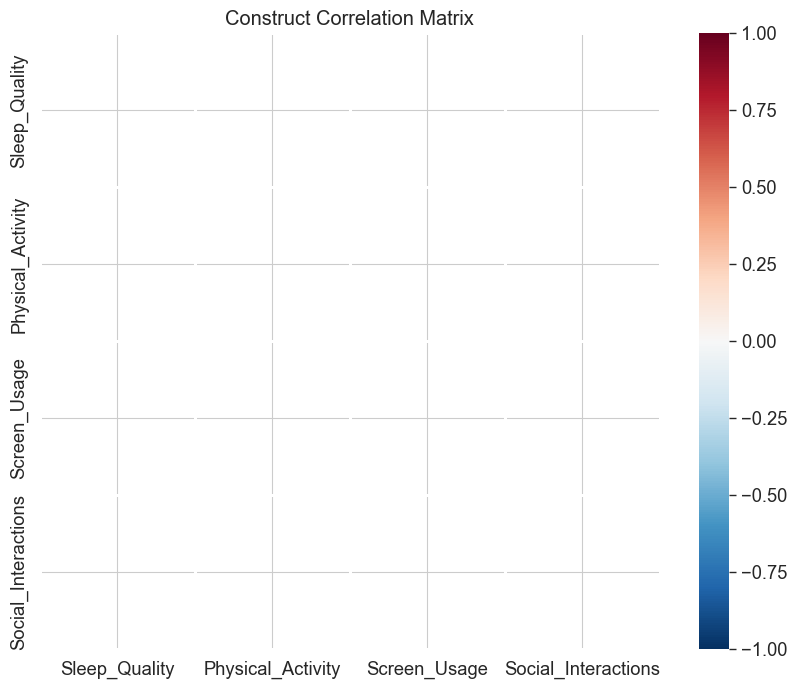

In [23]:
# Drop rows where we couldn't calculate all constructs
df_final = df_constructs.dropna()
print(f"Final Sample Size for Analysis: {len(df_final)} participant-days")

# Correlation Matrix
plt.figure(figsize=(10, 8))
corr = df_final.corr()
sns.heatmap(corr, annot=True, cmap='RdBu_r', center=0, vmin=-1, vmax=1, linewidths=1)
plt.title("Construct Correlation Matrix")
plt.show()

### 5.1 The Human/Domain DAG
Based on literature and the observed correlations, we define the Ground Truth DAG that represents "Human Reasoning".

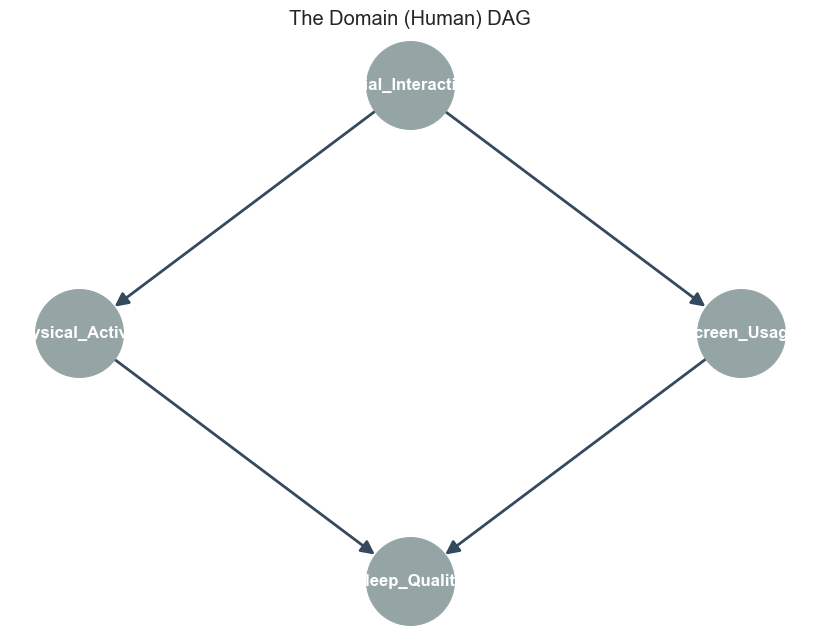

In [24]:
import networkx as nx

G_domain = nx.DiGraph()

# HYPOTHESIS:
# 1. Physical Activity -> Improves Sleep Quality
# 2. Screen Usage -> Degrades Sleep Quality (if inverse corr found)
# 3. Social Interaction -> Drives Physical Activity (getting out)
# 4. Social Interaction -> Affects Screen Usage (Calls vs Scrolling)

edges = [
    ("Physical_Activity", "Sleep_Quality"),
    ("Screen_Usage", "Sleep_Quality"),
    ("Social_Interactions", "Physical_Activity"),
    ("Social_Interactions", "Screen_Usage")
]

G_domain.add_edges_from(edges)

plt.figure(figsize=(8, 6))
pos = nx.shell_layout(G_domain)
nx.draw(G_domain, pos, with_labels=True, 
        node_color='#95a5a6', 
        node_size=4000, 
        font_color='white',
        font_weight='bold',
        width=2,
        edge_color='#34495e',
        arrowsize=20)
plt.title("The Domain (Human) DAG")
plt.show()

In [25]:
# Save Data for Model Training
output_path = os.path.join(DATA_DIR, 'processed_constructs.csv')
df_final.to_csv(output_path)
print(f"Successfully saved processed data to: {output_path}")

Successfully saved processed data to: ../Data/processed_constructs.csv
